In [1]:
# The idea is to use nWindows (say 3), and look at dependency upon sorting by window_mean.

# Note that key_1.csv shows that we are supposed to predict about 2 months worth of future data based on data
# lasting from 2015-07-01 to 2016-12-31.

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.preprocessing import (PolynomialFeatures, FunctionTransformer, StandardScaler)
from sklearn.pipeline import (make_pipeline, make_union, Pipeline, FeatureUnion)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

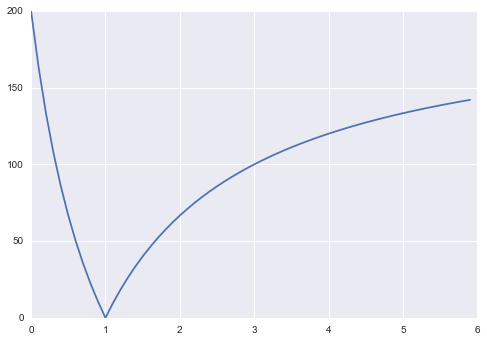

In [3]:
# Reference for performace measured by reference function. For a term |y_test - y_predict| / (|y_test| + |y_predict|) * 2 * 100,
# we look at when y_predict = alpha * y_test. Look at term as a function of alpha.

alpha = np.arange(0.0, 6.0, 0.1)
num = np.abs(1 - alpha)
denom = 1 + np.abs(alpha)
smapeVals = num / denom * 2 * 100

plt.plot(alpha, smapeVals)
plt.show()

In [4]:
all_df = pd.read_csv('train_1.csv')
all_df.shape

(145063, 551)

In [5]:
# For now, just set all NaN to 0.

all_df.fillna(0, inplace = True)

In [6]:
futureT = 64

X_all = all_df.drop('Page', axis = 1).values[:, :-futureT]
Y_all = all_df.drop('Page', axis = 1).values[:, -futureT:]

In [7]:
X_trainvalid, X_test, Y_trainvalid, Y_test = train_test_split(X_all, Y_all, test_size = 0.33, random_state = 32)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_trainvalid, Y_trainvalid, test_size = 0.33, random_state = 35)

print('X_train.shape = ', X_train.shape, '\tX_valid.shape = ', X_valid.shape, '\tX_test.shape = ', X_test.shape)
print('Y_train.shape = ', Y_train.shape, '\tY_valid.shape = ', Y_valid.shape, '\tY_test.shape = ', Y_test.shape)

X_train.shape =  (65118, 486) 	X_valid.shape =  (32074, 486) 	X_test.shape =  (47871, 486)
Y_train.shape =  (65118, 64) 	Y_valid.shape =  (32074, 64) 	Y_test.shape =  (47871, 64)


In [41]:
def smape(Y_predict, Y_test):
    result = np.linalg.norm(Y_predict - Y_test, axis = 1)
    result = np.abs(result)
    denom = np.linalg.norm(Y_predict, axis = 1)
    denom += np.linalg.norm(Y_test, axis = 1)
    result /= denom
    result *= 100 * 2
    result = np.mean(result)
    return result

def smape_scorer(estimator, X, Y):
    Ypredict = estimator.predict(X)
    result = smape(Y, Ypredict)
    return -result

def window_means(X, nWindows, windowSize):
    nSamples, nTimes = X.shape
    means = np.empty((nSamples, 0))
    for i in range(nWindows):
        newCol = X[:, nTimes - 1 - (i+1) * windowSize : nTimes - 1 - i * windowSize].mean(axis = 1, keepdims = True)
        means = np.hstack((means, newCol))
    return means

def all_features(X, nWindows, windowSize):
    nSamples, nTimes = X.shape
    means = window_means(X, nWindows, windowSize)
    linear = np.empty((nSamples, 0))
    
    # Make linear and quadratic arrays orthogonal to each other.
    const = np.full(windowSize, 1 / np.sqrt(windowSize))
    lin = np.arange(windowSize) - (windowSize - 1) / 2
    
    for i in range(nWindows):
        X_window = X[:, nTimes - 1 - (i + 1)*windowSize : nTimes - 1 - i * windowSize]
        newCol = np.dot(X_window, lin).reshape(-1,1)
        means = np.hstack((means, newCol))
        
    return means

In [13]:
# Let's try decision tree on different window means.

def Ztransform(Y, param):
    return np.log(param + Y)

def inverseZ(Z, param):
    return -param + np.exp(Z)

param = 15
Z_train = Ztransform(Y_train, param)
Z_valid = Ztransform(Y_valid, param)

model = Pipeline([ ('means', FunctionTransformer(window_means, kw_args = {'nWindows' : 3, 'windowSize' : 150})),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])
model.fit(X_train, Z_train)
Z_predict = model.predict(X_valid)
Y_predict = inverseZ(Z_predict, param)
print('smape = ', smape(1e-6 + Y_predict, Y_valid))

smape =  82.7346628249


param 1 	smape =  83.6524856405param 4 	smape =  83.3910174578param 7 	smape =  83.1425505881param 10 	smape =  82.9541523974param 13 	smape =  82.8200128117param 16 	smape =  82.6895712717param 19 	smape =  82.7273382932param 22 	smape =  82.8421652862param 25 	smape =  82.8160540403param 28 	smape =  82.8427152682

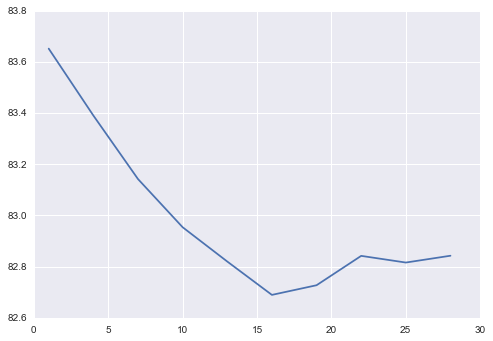

In [15]:
# Let's try parameter search.

param_search = np.arange(1, 30, 3)
smapes = []
for param in param_search:
    Z_train = Ztransform(Y_train, param)
    Z_valid = Ztransform(Y_valid, param)
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = inverseZ(Z_predict, param)
    newsmape = smape(1e-6 + Y_predict, Y_valid)
    print('param', param, '\tsmape = ', newsmape, end = '')
    smapes.append(newsmape)
plt.plot(param_search, smapes)
plt.show()

depth 7 	smape =  83.1881898567depth 8 	smape =  82.7730816021depth 9 	smape =  82.7586300525depth 10 	smape =  82.7044908517depth 11 	smape =  83.1726648796depth 12 	smape =  83.7438387558

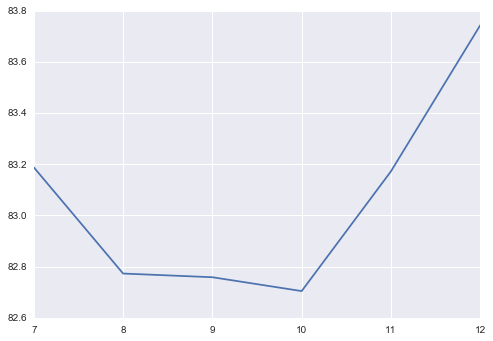

In [17]:
# Let's try parameter search.

depth_search = np.arange(7, 13, 1)
param = 16
smapes = []
for depth in depth_search:
    Z_train = Ztransform(Y_train, param)
    Z_valid = Ztransform(Y_valid, param)
    model.set_params(tree__max_depth = depth)
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = inverseZ(Z_predict, param)
    newsmape = smape(1e-6 + Y_predict, Y_valid)
    print('depth', depth, '\tsmape = ', newsmape, end = '')
    smapes.append(newsmape)
plt.plot(depth_search, smapes)
plt.show()

In [42]:
# Let's try decision tree on different window means.

def Ztransform(Y, param):
    return np.log(param + Y)

def inverseZ(Z, param):
    return -param + np.exp(Z)

param = 15
Z_train = Ztransform(Y_train, param)
Z_valid = Ztransform(Y_valid, param)

model = Pipeline([ ('means', FunctionTransformer(all_features, kw_args = {'nWindows' : 3, 'windowSize' : 150})),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])
model.fit(X_train, Z_train)
Z_predict = model.predict(X_valid)
Y_predict = inverseZ(Z_predict, param)
print('smape = ', smape(1e-6 + Y_predict, Y_valid))

smape =  80.893475202
